In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import make_scorer

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn import linear_model
from sklearn.model_selection import train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression



pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)


In [2]:
# read in the dataframe

df = pd.read_csv("Life_Expectancy_No_Missing_Vals.csv").set_index('Unnamed: 0')

## Is Status something we want in our model?

In [7]:
cont = ['adult_mortality','infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under-five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv/aids', 'thinness__10-19_years', 'thinness_5-9_years',
       'gdp', 'population', 'income_composition_of_resources', 'schooling']

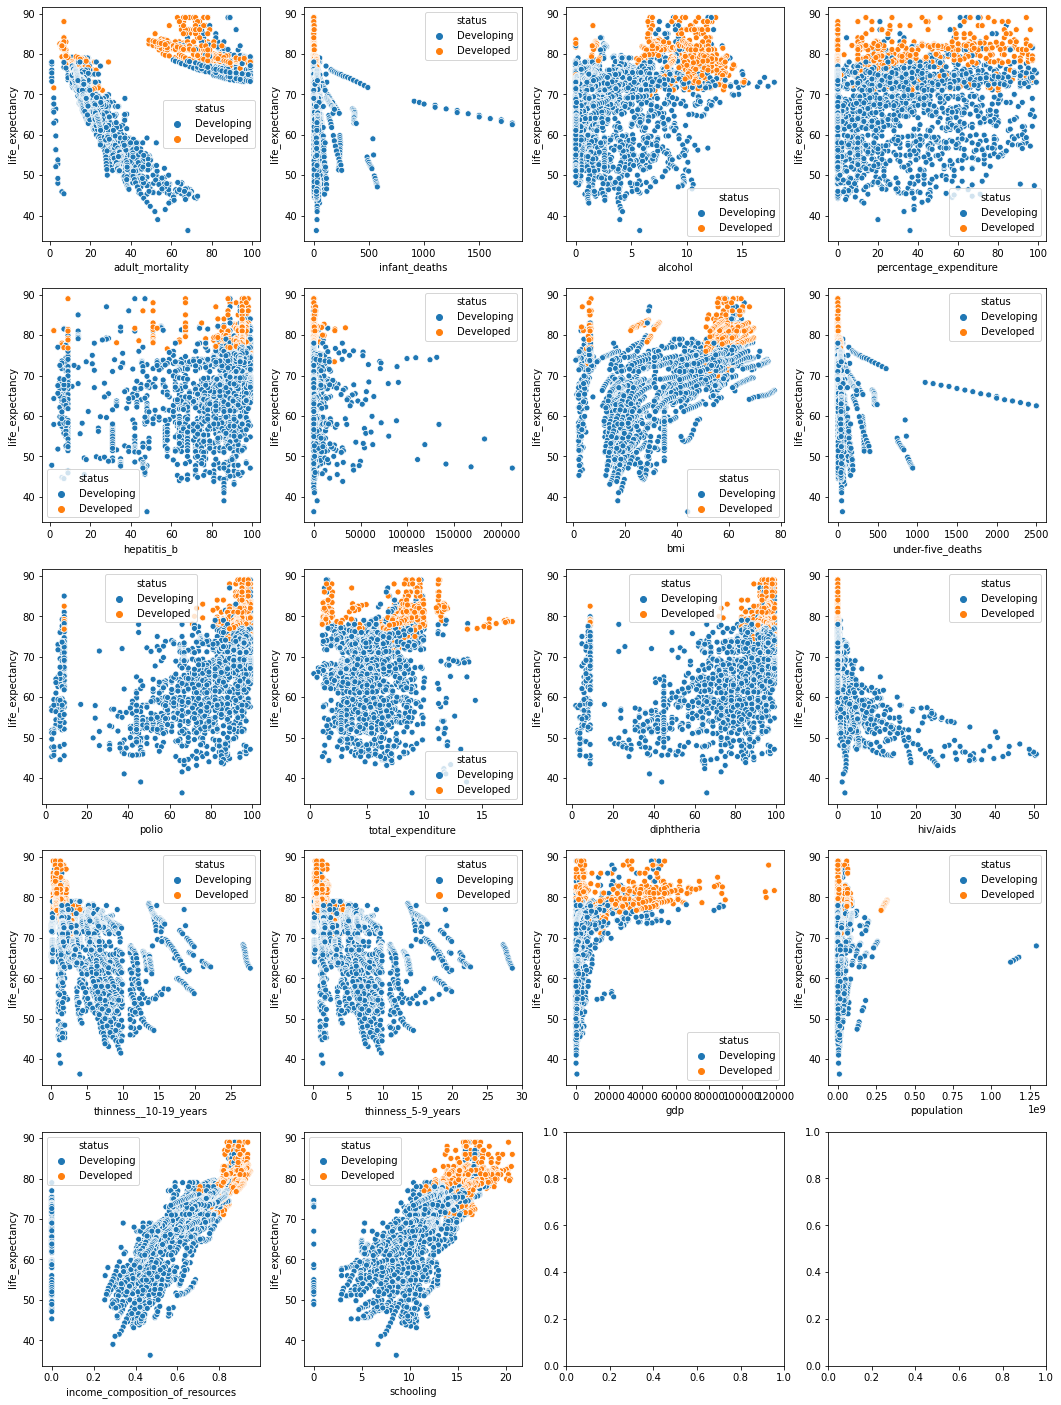

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(18,25))

for i, col in enumerate(cont):
    sns.scatterplot(x=df[col], y=df['life_expectancy'], hue=df['status'], ax=axes[i//4][i%4])
    #print(i//4, i%4)

#### From the above graph, we will make the following decisions for our model:

- We will not include status as a predictor. It seems all developed countries have a life expectancy of above 75. 
- We want to see how variables that can actually *be changed by a government to increase their countries health* affect life expectancy
- We will also not include country or year in our models. Government leaders cannot change these variables in the hopes of increasing their country's life expectancy

In [9]:
# Now, lets get a df of all our features

features = df[['adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure',
 'hepatitis_b', 'measles','bmi', 'under-five_deaths', 'polio', 'total_expenditure', 'diphtheria',
 'hiv/aids', 'gdp', 'population', 'thinness__10-19_years', 'thinness_5-9_years', 'income_composition_of_resources',
 'schooling']]

# First Model - Nothing Fancy

Our first model to get a baseline idea will simply put our predictor variables against our target variable. Note we will apply a standard scaler to all our models so we are working in a standard scale.

In [10]:
X1 = features.copy()
y1 = df.life_expectancy

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [12]:
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X1.columns)

#transform the testing dat
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X1.columns)

In [13]:
#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 4.281193313137996


In [14]:
#use fitted model to predict on the test examples
y_test_pred = lm.predict(X_test)

#evaluate the predictions on the test examples
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training: ', train_rmse, "vs. Testing: ", test_rmse)

Testing Root Mean Squared Error: 4.011609896415526
Training:  4.281193313137996 vs. Testing:  4.011609896415526


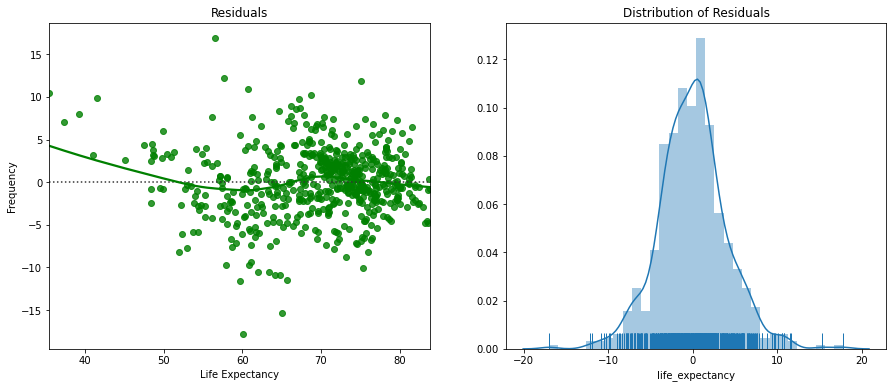

In [15]:
fig = plt.figure(figsize=(15,6))

ax1 = plt.subplot(121)
sns.residplot(y_test_pred, y_test, lowess=True, color="g", ax=ax1)
ax1.set_title("Residuals")
ax1.set_xlabel("Life Expectancy")

ax2 = plt.subplot(122)
sns.distplot((y_test_pred- y_test), kde=True, rug=True, ax=ax2)
ax2.set_title("Distribution of Residuals")
ax1.set_ylabel("Frequency")
plt.show()



In [16]:
X1 = sm.add_constant(X1)
model = sm.OLS(y1,X1)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     658.6
Date:                Thu, 10 Sep 2020   Prob (F-statistic):               0.00
Time:                        18:28:45   Log-Likelihood:                -8375.1
No. Observations:                2928   AIC:                         1.679e+04
Df Residuals:                    2909   BIC:                         1.690e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              47.1682      0.516     91.416      0.000      46.157      48.180
adult_mortality                     0.0116      0.004      3.209      0.001       0.005       0.019
infant_deaths                       0.1052      0.009     11.908      0.000       0.088       0.122
alcohol                             0.0151      0.025      0.597      0.551      -0.034       0.065
percentage_expenditure              0.0111      0.003      3.730      0.000       0.005       0.017
hepatitis_b                        -0.0021      0.004     -0.507      0.612      -0.010       0.006
measles                         -2.548e-06   8.01e-06     -0.318      0.750   -1.82e-05    1.32e-05
bmi                                 0.0478      0.005      9.203      0.000       0.038       0.058
under-five_deaths                  -0.0780      0.006    -12.029      0.000      -0.091      -0.065
polio                               0.0318      0.005      6.763      0.000       0.023       0.041
total_expenditure                   0.0253      0.035      0.723      0.470      -0.043       0.094
diphtheria                          0.0316      0.005      6.275      0.000       0.022       0.041
hiv/aids                           -0.6663      0.017    -39.192      0.000      -0.700      -0.633
gdp                              6.639e-05    6.9e-06      9.621      0.000    5.29e-05    7.99e-05
population                       -1.16e-09    1.6e-09     -0.725      0.469    -4.3e-09    1.98e-09
thinness__10-19_years              -0.0747      0.053     -1.416      0.157      -0.178       0.029
thinness_5-9_years                 -0.0177      0.052     -0.340      0.734      -0.120       0.084
income_composition_of_resources     7.3604      0.668     11.023      0.000       6.051       8.670
schooling                           0.9034      0.045     19.982      0.000       0.815       0.992
==============================================================================
Omnibus:                      172.988   Durbin-Watson:                   0.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              733.988
Skew:                          -0.017   Prob(JB):                    4.13e-160
Kurtosis:                       5.453   Cond. No.                     5.24e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.24e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Second Model - Tweak the first, remove large p-values

This model won't be too different, we want to see what happens when we remove statistically insignificant features. We determines which to remove based on any feature that had a p-value < .05 from our last OLS summary

In [24]:
X2 = features[['adult_mortality', 'infant_deaths', 'percentage_expenditure',
       'bmi', 'under-five_deaths', 'polio',
       'diphtheria', 'hiv/aids', 'gdp', 
       'income_composition_of_resources', 'schooling']].copy()
y2 = df.life_expectancy

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [26]:
scaler2 = StandardScaler()

# fit the scaler to the training data
scaler2.fit(X_train)

#transform the training data
X_train = pd.DataFrame(data=scaler2.transform(X_train), columns=X2.columns)

#transform the testing dat
X_test = pd.DataFrame(data=scaler2.transform(X_test), columns=X2.columns)

In [27]:
#instantiate a linear regression object
lm2 = LinearRegression()

#fit the linear regression to the data
lm2 = lm2.fit(X_train, y_train)

y_train_pred = lm2.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 4.29910803758681


In [28]:
#use fitted model to predict on the test examples
y_test_pred = lm2.predict(X_test)

#evaluate the predictions on the test examples
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training: ', train_rmse, "vs. Testing: ", test_rmse)

Testing Root Mean Squared Error: 3.998787116869268
Training:  4.29910803758681 vs. Testing:  3.998787116869268


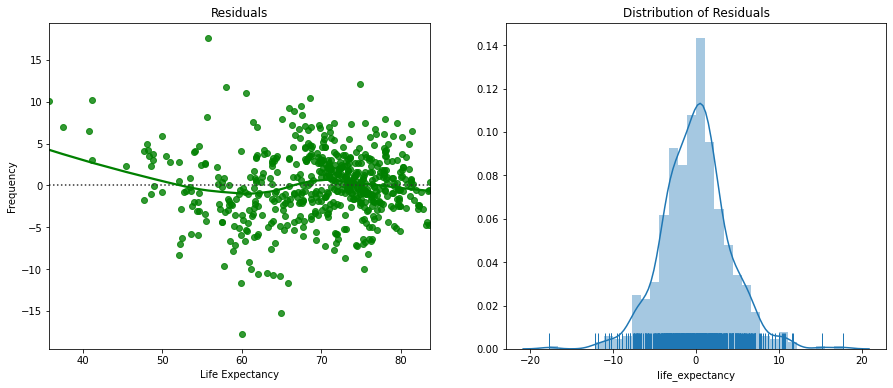

In [29]:
fig = plt.figure(figsize=(15,6))

ax1 = plt.subplot(121)
sns.residplot(y_test_pred, y_test, lowess=True, color="g", ax=ax1)
ax1.set_title("Residuals")
ax1.set_xlabel("Life Expectancy")

ax2 = plt.subplot(122)
sns.distplot((y_test_pred- y_test), kde=True, rug=True, ax=ax2)
ax2.set_title("Distribution of Residuals")
ax1.set_ylabel("Frequency")
plt.show()

In [30]:
X2 = sm.add_constant(X2)
model = sm.OLS(y2,X2)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     1072.
Date:                Thu, 10 Sep 2020   Prob (F-statistic):               0.00
Time:                        18:30:19   Log-Likelihood:                -8384.3
No. Observations:                2928   AIC:                         1.679e+04
Df Residuals:                    2916   BIC:                         1.686e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              46.2019      0.416    111.143      0.000      45.387      47.017
adult_mortality                     0.0123      0.004      3.430      0.001       0.005       0.019
infant_deaths                       0.0998      0.009     11.690      0.000       0.083       0.117
percentage_expenditure              0.0112      0.003      3.760      0.000       0.005       0.017
bmi                                 0.0549      0.005     11.304      0.000       0.045       0.064
under-five_deaths                  -0.0752      0.006    -11.920      0.000      -0.088      -0.063
polio                               0.0312      0.005      6.717      0.000       0.022       0.040
diphtheria                          0.0305      0.005      6.547      0.000       0.021       0.040
hiv/aids                           -0.6704      0.017    -40.053      0.000      -0.703      -0.638
gdp                              6.873e-05   6.79e-06     10.124      0.000    5.54e-05     8.2e-05
income_composition_of_resources     7.4753      0.664     11.256      0.000       6.173       8.778
schooling                           0.9324      0.043     21.760      0.000       0.848       1.016
==============================================================================
Omnibus:                      180.908   Durbin-Watson:                   0.506
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              797.918
Skew:                           0.033   Prob(JB):                    5.42e-174
Kurtosis:                       5.557   Cond. No.                     1.35e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Third Model - Poly 2 degree without removing any features (we will remove later)

From the above p-values, we can see that all of them are significant. But, our model can probably still be improved. To see where we are missing some of our target's unexplained variance, we will create a polynomial model to see some relations. 



In [45]:
X3 = features.copy()
y3 = df.life_expectancy

In [46]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(X3)
poly2_columns = poly_2.get_feature_names(X3.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
df_poly2.head()

,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness__10-19_years,thinness_5-9_years,income_composition_of_resources,schooling,adult_mortality^2,adult_mortality infant_deaths,adult_mortality alcohol,adult_mortality percentage_expenditure,adult_mortality hepatitis_b,adult_mortality measles,adult_mortality bmi,adult_mortality under-five_deaths,adult_mortality polio,adult_mortality total_expenditure,adult_mortality diphtheria,adult_mortality hiv/aids,adult_mortality gdp,adult_mortality population,adult_mortality thinness__10-19_years,adult_mortality thinness_5-9_years,adult_mortality income_composition_of_resources,adult_mortality schooling,infant_deaths^2,infant_deaths alcohol,infant_deaths percentage_expenditure,infant_deaths hepatitis_b,infant_deaths measles,infant_deaths bmi,infant_deaths under-five_deaths,infant_deaths polio,infant_deaths total_expenditure,infant_deaths diphtheria,infant_deaths hiv/aids,infant_deaths gdp,infant_deaths population,infant_deaths thinness__10-19_years,infant_deaths thinness_5-9_years,infant_deaths income_composition_of_resources,infant_deaths schooling,alcohol^2,alcohol percentage_expenditure,alcohol hepatitis_b,alcohol measles,alcohol bmi,alcohol under-five_deaths,alcohol polio,alcohol total_expenditure,alcohol diphtheria,alcohol hiv/aids,alcohol gdp,alcohol population,alcohol thinness__10-19_years,alcohol thinness_5-9_years,alcohol income_composition_of_resources,alcohol schooling,percentage_expenditure^2,percentage_expenditure hepatitis_b,percentage_expenditure measles,percentage_expenditure bmi,percentage_expenditure under-five_deaths,percentage_expenditure polio,percentage_expenditure total_expenditure,percentage_expenditure diphtheria,percentage_expenditure hiv/aids,percentage_expenditure gdp,percentage_expenditure population,percentage_expenditure thinness__10-19_years,percentage_expenditure thinness_5-9_years,percentage_expenditure income_composition_of_resources,percentage_expenditure schooling,hepatitis_b^2,hepatitis_b measles,hepatitis_b bmi,hepatitis_b under-five_deaths,hepatitis_b polio,hepatitis_b total_expenditure,hepatitis_b diphtheria,hepatitis_b hiv/aids,hepatitis_b gdp,hepatitis_b population,hepatitis_b thinness__10-19_years,hepatitis_b thinness_5-9_years,hepatitis_b income_composition_of_resources,hepatitis_b schooling,measles^2,measles bmi,measles under-five_deaths,measles polio,measles total_expenditure,measles diphtheria,measles hiv/aids,measles gdp,measles population,measles thinness__10-19_years,measles thinness_5-9_years,measles income_composition_of_resources,measles schooling,bmi^2,bmi under-five_deaths,bmi polio,bmi total_expenditure,bmi diphtheria,bmi hiv/aids,bmi gdp,bmi population,bmi thinness__10-19_years,bmi thinness_5-9_years,bmi income_composition_of_resources,bmi schooling,under-five_deaths^2,under-five_deaths polio,under-five_deaths total_expenditure,under-five_deaths diphtheria,under-five_deaths hiv/aids,under-five_deaths gdp,under-five_deaths population,under-five_deaths thinness__10-19_years,under-five_deaths thinness_5-9_years,under-five_deaths income_composition_of_resources,under-five_deaths schooling,polio^2,polio total_expenditure,polio diphtheria,polio hiv/aids,polio gdp,polio population,polio thinness__10-19_years,polio thinness_5-9_years,polio income_composition_of_resources,polio schooling,total_expenditure^2,total_expenditure diphtheria,total_expenditure hiv/aids,total_expenditure gdp,total_expenditure population,total_expenditure thinness__10-19_years,total_expenditure thinness_5-9_years,total_expenditure income_composition_of_resources,total_expenditure schooling,diphtheria^2,diphtheria hiv/aids,diphtheria gdp,diphtheria population,diphtheria thinness__10-19_years,diphtheria thinness_5-9_years,diphtheria income_composition_of_resources,diphtheria schooling,hiv/aids^2,hiv/aids gdp,hiv/aids population,hiv/aids thinness__10-19_ye

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2, y3, test_size=0.2, random_state=42)

In [48]:
scaler3 = StandardScaler()

# fit the scaler to the training data
scaler3.fit(X_train)

#transform the training data
X_train = pd.DataFrame(data=scaler3.transform(X_train), columns=df_poly2.columns)

#transform the testing dat
X_test = pd.DataFrame(data=scaler3.transform(X_test), columns=df_poly2.columns)

In [49]:
# instantiate a linear regression object
lm_3 = LinearRegression()

#fit the linear regression to the data
lm_3 = lm_3.fit(X_train, y_train)

y_train_pred = lm_3.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 2.577540745894145


In [50]:
# use fitted model to predict on test data
y_pred = lm_3.predict(X_test)

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training: ', train_rmse, "vs. Testing: ", test_rmse)

Testing Root Mean Squared Error: 3.7075513181779347
Training:  2.577540745894145 vs. Testing:  3.7075513181779347


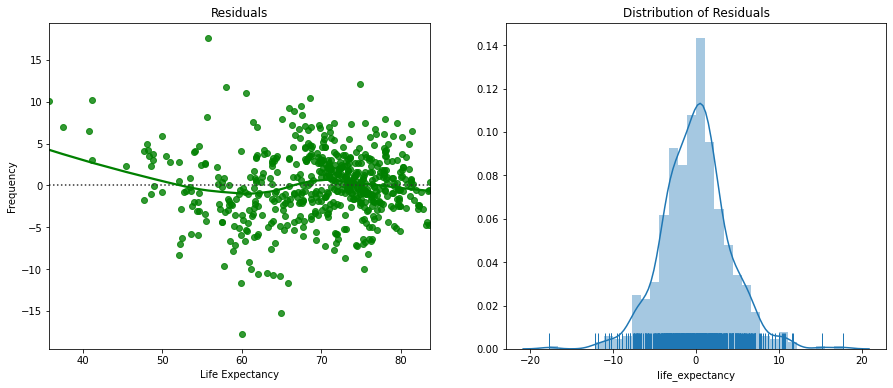

In [51]:
fig = plt.figure(figsize=(15,6))

ax1 = plt.subplot(121)
sns.residplot(y_test_pred, y_test, lowess=True, color="g", ax=ax1)
ax1.set_title("Residuals")
ax1.set_xlabel("Life Expectancy")

ax2 = plt.subplot(122)
sns.distplot((y_test_pred- y_test), kde=True, rug=True, ax=ax2)
ax2.set_title("Distribution of Residuals")
ax1.set_ylabel("Frequency")
plt.show()

Since the testing rmse is far worse than the training rmse, we overfit. This makes sense since we included every single column. Let's remove some using different methods below.

## Fourth Model - Poly 2 degree by removing features based on VIF score


In [63]:
X4 = features.copy()
y4 = df.life_expectancy

In [64]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(X4)
poly2_columns = poly_2.get_feature_names(X4.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
df_poly2.head()

,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness__10-19_years,thinness_5-9_years,income_composition_of_resources,schooling,adult_mortality^2,adult_mortality infant_deaths,adult_mortality alcohol,adult_mortality percentage_expenditure,adult_mortality hepatitis_b,adult_mortality measles,adult_mortality bmi,adult_mortality under-five_deaths,adult_mortality polio,adult_mortality total_expenditure,adult_mortality diphtheria,adult_mortality hiv/aids,adult_mortality gdp,adult_mortality population,adult_mortality thinness__10-19_years,adult_mortality thinness_5-9_years,adult_mortality income_composition_of_resources,adult_mortality schooling,infant_deaths^2,infant_deaths alcohol,infant_deaths percentage_expenditure,infant_deaths hepatitis_b,infant_deaths measles,infant_deaths bmi,infant_deaths under-five_deaths,infant_deaths polio,infant_deaths total_expenditure,infant_deaths diphtheria,infant_deaths hiv/aids,infant_deaths gdp,infant_deaths population,infant_deaths thinness__10-19_years,infant_deaths thinness_5-9_years,infant_deaths income_composition_of_resources,infant_deaths schooling,alcohol^2,alcohol percentage_expenditure,alcohol hepatitis_b,alcohol measles,alcohol bmi,alcohol under-five_deaths,alcohol polio,alcohol total_expenditure,alcohol diphtheria,alcohol hiv/aids,alcohol gdp,alcohol population,alcohol thinness__10-19_years,alcohol thinness_5-9_years,alcohol income_composition_of_resources,alcohol schooling,percentage_expenditure^2,percentage_expenditure hepatitis_b,percentage_expenditure measles,percentage_expenditure bmi,percentage_expenditure under-five_deaths,percentage_expenditure polio,percentage_expenditure total_expenditure,percentage_expenditure diphtheria,percentage_expenditure hiv/aids,percentage_expenditure gdp,percentage_expenditure population,percentage_expenditure thinness__10-19_years,percentage_expenditure thinness_5-9_years,percentage_expenditure income_composition_of_resources,percentage_expenditure schooling,hepatitis_b^2,hepatitis_b measles,hepatitis_b bmi,hepatitis_b under-five_deaths,hepatitis_b polio,hepatitis_b total_expenditure,hepatitis_b diphtheria,hepatitis_b hiv/aids,hepatitis_b gdp,hepatitis_b population,hepatitis_b thinness__10-19_years,hepatitis_b thinness_5-9_years,hepatitis_b income_composition_of_resources,hepatitis_b schooling,measles^2,measles bmi,measles under-five_deaths,measles polio,measles total_expenditure,measles diphtheria,measles hiv/aids,measles gdp,measles population,measles thinness__10-19_years,measles thinness_5-9_years,measles income_composition_of_resources,measles schooling,bmi^2,bmi under-five_deaths,bmi polio,bmi total_expenditure,bmi diphtheria,bmi hiv/aids,bmi gdp,bmi population,bmi thinness__10-19_years,bmi thinness_5-9_years,bmi income_composition_of_resources,bmi schooling,under-five_deaths^2,under-five_deaths polio,under-five_deaths total_expenditure,under-five_deaths diphtheria,under-five_deaths hiv/aids,under-five_deaths gdp,under-five_deaths population,under-five_deaths thinness__10-19_years,under-five_deaths thinness_5-9_years,under-five_deaths income_composition_of_resources,under-five_deaths schooling,polio^2,polio total_expenditure,polio diphtheria,polio hiv/aids,polio gdp,polio population,polio thinness__10-19_years,polio thinness_5-9_years,polio income_composition_of_resources,polio schooling,total_expenditure^2,total_expenditure diphtheria,total_expenditure hiv/aids,total_expenditure gdp,total_expenditure population,total_expenditure thinness__10-19_years,total_expenditure thinness_5-9_years,total_expenditure income_composition_of_resources,total_expenditure schooling,diphtheria^2,diphtheria hiv/aids,diphtheria gdp,diphtheria population,diphtheria thinness__10-19_years,diphtheria thinness_5-9_years,diphtheria income_composition_of_resources,diphtheria schooling,hiv/aids^2,hiv/aids gdp,hiv/aids population,hiv/aids thinness__10-19_ye

In [146]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2, y3, test_size=0.2, random_state=42)

In [66]:
## Remove with VIF

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif.round(1)

,VIF Factor,features
0,41.0,adult_mortality
1,434.4,infant_deaths
2,44.5,alcohol
3,39.5,percentage_expenditure
4,16.0,hepatitis_b
5,412.8,measles
6,36.0,bmi
7,454.3,under-five_deaths
8,15.4,polio
9,16.6,total_expenditure


In [147]:
# Take the 10% best columns based on VIF

## NOTE 66% of best features gives the best results, decreasing slowly makes model worse, and increaseing to 67 
## drastically reduces rmse

vif_features = list(vif[vif['VIF Factor'] <= np.percentile(vif['VIF Factor'], 66)]['features'])
#vif_features

In [165]:
#vif[vif['VIF Factor'] <= np.percentile(vif['VIF Factor'], 67)].sort_values(by='VIF Factor', ascending=False)

In [166]:
# Update X_train and X_test to only have these columns
X_train = X_train.copy()[vif_features]
X_test = X_test.copy()[vif_features]

In [167]:
scaler4 = StandardScaler()

# fit the scaler to the training data
scaler4.fit(X_train)

#transform the training data
X_train = pd.DataFrame(data=scaler4.transform(X_train), columns=X_train.columns)

#transform the testing dat
X_test = pd.DataFrame(data=scaler4.transform(X_test), columns=X_train.columns)

In [168]:
# instantiate a linear regression object
lm_4 = LinearRegression()

#fit the linear regression to the data
lm_4 = lm_4.fit(X_train, y_train)

y_train_pred = lm_4.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 2.8849557757536473


In [182]:
# use fitted model to predict on test data
y_pred = lm_4.predict(X_test)

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training: ', train_rmse, "vs. Testing: ", test_rmse)
print(f"R2: {metrics.r2_score(y_test, y_pred)}")

Testing Root Mean Squared Error: 2.963968025084428
Training:  2.8849557757536473 vs. Testing:  2.963968025084428
R2: 0.8984373739260028


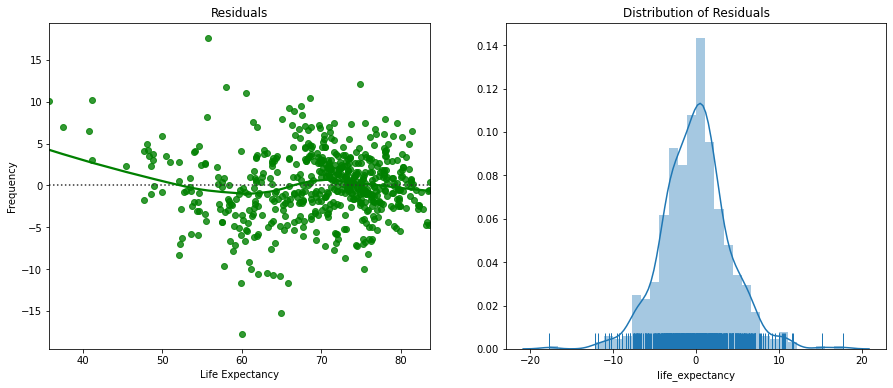

In [152]:
fig = plt.figure(figsize=(15,6))

ax1 = plt.subplot(121)
sns.residplot(y_test_pred, y_test, lowess=True, color="g", ax=ax1)
ax1.set_title("Residuals")
ax1.set_xlabel("Life Expectancy")

ax2 = plt.subplot(122)
sns.distplot((y_test_pred- y_test), kde=True, rug=True, ax=ax2)
ax2.set_title("Distribution of Residuals")
ax1.set_ylabel("Frequency")
plt.show()

In [188]:
#len(lm_4.coef_), len(X_train.columns)
coefs = pd.DataFrame(X_train.columns, lm_4.coef_, columns=['Feature']).reset_index().rename({'index':'Coef'}, axis=1)
top_15_pos_coefs = coefs.sort_values(by='Coef', ascending=False)[:15]
top_15_neg_coefs = coefs.sort_values(by='Coef', ascending=True)[:15]
top_15_pos_coefs

,Coef,Feature
122,13.554007,income_composition_of_resources^2
27,7.416848,adult_mortality schooling
124,4.575918,schooling^2
13,4.134842,adult_mortality^2
4,3.906764,bmi
1,3.876529,alcohol
86,2.847466,polio^2
68,1.601909,hepatitis_b income_composition_of_resources
53,1.511196,percentage_expenditure thinness__10-19_years
2,1.431781,percentage_expenditure


#### Let's take a look at our top 15 best predictors from a positive ane a negative standpoint

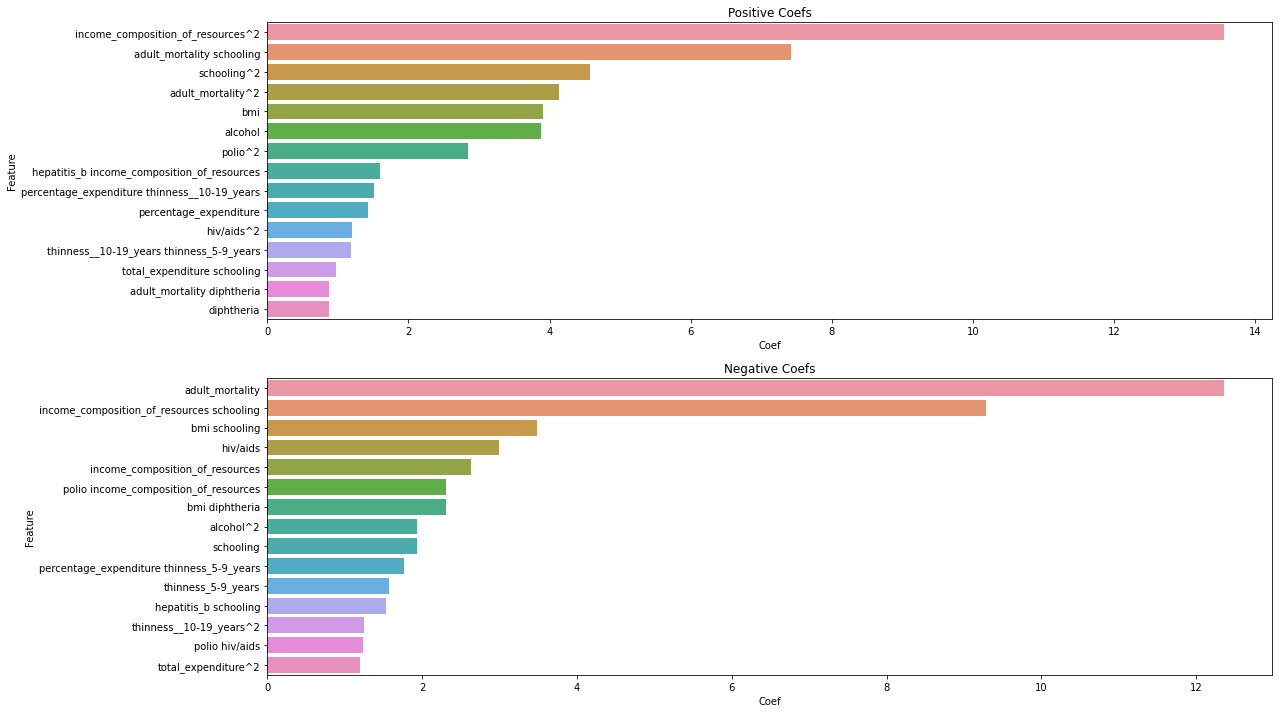

In [194]:
fig = plt.subplots(figsize=(18,12))

ax1 = plt.subplot(211)
ax1.set_title("Positive Coefs")
sns.barplot(y = top_15_pos_coefs.Feature, x = top_15_pos_coefs.Coef, ax=ax1)

ax2 = plt.subplot(212)
ax2.set_title("Negative Coefs")
sns.barplot(y = top_15_neg_coefs.Feature, x = abs(top_15_neg_coefs.Coef), ax=ax2)


# Fifth Model - Poly 2 degree by selecting best features (f-test, SelectKBest library)

Select KBest features using F Test.

In [195]:
X5 = features.copy()
y5 = df.life_expectancy

In [196]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(X5)
poly2_columns = poly_2.get_feature_names(X5.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
df_poly2.head()

,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness__10-19_years,thinness_5-9_years,income_composition_of_resources,schooling,adult_mortality^2,adult_mortality infant_deaths,adult_mortality alcohol,adult_mortality percentage_expenditure,adult_mortality hepatitis_b,adult_mortality measles,adult_mortality bmi,adult_mortality under-five_deaths,adult_mortality polio,adult_mortality total_expenditure,adult_mortality diphtheria,adult_mortality hiv/aids,adult_mortality gdp,adult_mortality population,adult_mortality thinness__10-19_years,adult_mortality thinness_5-9_years,adult_mortality income_composition_of_resources,adult_mortality schooling,infant_deaths^2,infant_deaths alcohol,infant_deaths percentage_expenditure,infant_deaths hepatitis_b,infant_deaths measles,infant_deaths bmi,infant_deaths under-five_deaths,infant_deaths polio,infant_deaths total_expenditure,infant_deaths diphtheria,infant_deaths hiv/aids,infant_deaths gdp,infant_deaths population,infant_deaths thinness__10-19_years,infant_deaths thinness_5-9_years,infant_deaths income_composition_of_resources,infant_deaths schooling,alcohol^2,alcohol percentage_expenditure,alcohol hepatitis_b,alcohol measles,alcohol bmi,alcohol under-five_deaths,alcohol polio,alcohol total_expenditure,alcohol diphtheria,alcohol hiv/aids,alcohol gdp,alcohol population,alcohol thinness__10-19_years,alcohol thinness_5-9_years,alcohol income_composition_of_resources,alcohol schooling,percentage_expenditure^2,percentage_expenditure hepatitis_b,percentage_expenditure measles,percentage_expenditure bmi,percentage_expenditure under-five_deaths,percentage_expenditure polio,percentage_expenditure total_expenditure,percentage_expenditure diphtheria,percentage_expenditure hiv/aids,percentage_expenditure gdp,percentage_expenditure population,percentage_expenditure thinness__10-19_years,percentage_expenditure thinness_5-9_years,percentage_expenditure income_composition_of_resources,percentage_expenditure schooling,hepatitis_b^2,hepatitis_b measles,hepatitis_b bmi,hepatitis_b under-five_deaths,hepatitis_b polio,hepatitis_b total_expenditure,hepatitis_b diphtheria,hepatitis_b hiv/aids,hepatitis_b gdp,hepatitis_b population,hepatitis_b thinness__10-19_years,hepatitis_b thinness_5-9_years,hepatitis_b income_composition_of_resources,hepatitis_b schooling,measles^2,measles bmi,measles under-five_deaths,measles polio,measles total_expenditure,measles diphtheria,measles hiv/aids,measles gdp,measles population,measles thinness__10-19_years,measles thinness_5-9_years,measles income_composition_of_resources,measles schooling,bmi^2,bmi under-five_deaths,bmi polio,bmi total_expenditure,bmi diphtheria,bmi hiv/aids,bmi gdp,bmi population,bmi thinness__10-19_years,bmi thinness_5-9_years,bmi income_composition_of_resources,bmi schooling,under-five_deaths^2,under-five_deaths polio,under-five_deaths total_expenditure,under-five_deaths diphtheria,under-five_deaths hiv/aids,under-five_deaths gdp,under-five_deaths population,under-five_deaths thinness__10-19_years,under-five_deaths thinness_5-9_years,under-five_deaths income_composition_of_resources,under-five_deaths schooling,polio^2,polio total_expenditure,polio diphtheria,polio hiv/aids,polio gdp,polio population,polio thinness__10-19_years,polio thinness_5-9_years,polio income_composition_of_resources,polio schooling,total_expenditure^2,total_expenditure diphtheria,total_expenditure hiv/aids,total_expenditure gdp,total_expenditure population,total_expenditure thinness__10-19_years,total_expenditure thinness_5-9_years,total_expenditure income_composition_of_resources,total_expenditure schooling,diphtheria^2,diphtheria hiv/aids,diphtheria gdp,diphtheria population,diphtheria thinness__10-19_years,diphtheria thinness_5-9_years,diphtheria income_composition_of_resources,diphtheria schooling,hiv/aids^2,hiv/aids gdp,hiv/aids population,hiv/aids thinness__10-19_ye

In [293]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2, y5, test_size=0.2, random_state=42)

In [294]:
selector = SelectKBest(f_regression, k=79) # This number is the best we found, we played with it a bit
selector.fit(X_train, y_train)

SelectKBest(k=79, score_func=<function f_regression at 0x126761af0>)

In [295]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [296]:
#list(selected_columns)

In [297]:
#instantiate a linear regression object
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest = lm_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = lm_kbest.predict(X_train[selected_columns])


trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))


print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(X_test[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Root Mean Squared Error: 3.128028721013118
Testing Root Mean Squared Error: 3.297236015136076


From our results, it appears that we can not get as good of a model using an f test to select our best features. So far, selecting our best features via a VIF score has proven to be the best model.

# Sixth Model - Poly 2 degree by removing columns with Recursive Feature Elimination


In [ ]:
sns.scatterplot(df.adult_mortality, df.life_expectancy)